In [11]:
pip install python_speech_features

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=cd4dffee955e792373647e752901570dcbbc2b06336f6884e8244a6831bacf52
  Stored in directory: /root/.cache/pip/wheels/5b/60/87/28af2605138deac93d162904df42b6fdda1dab9b8757c62aa3
Successfully built python_speech_features
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
sys.path.insert(0, '/tf/utils/')

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from sound import Sound
from batch import DataGenerator
from python_speech_features import mfcc

In [14]:
def voice_activity_detection_advanced(audio_signal, sample_rate=8000, frame_length_ms=20, frame_shift_ms=10):
    # Convertendo o sinal de áudio para o formato mono, se necessário
    if len(audio_signal.shape) > 1:
        audio_signal = np.mean(audio_signal, axis=1)

    # Calculando o tamanho da janela em amostras
    frame_length_samples = int(sample_rate * (frame_length_ms / 1000.0))
    frame_shift_samples = int(sample_rate * (frame_shift_ms / 1000.0))

    # Calculando a energia do sinal em janelas sobrepostas
    energy = np.array([sum(abs(audio_signal[i:i + frame_length_samples]) ** 2)
                       for i in range(0, len(audio_signal), frame_shift_samples)])

    # Normalizando a energia
    energy /= max(energy)

    # Calcular o limiar dinamicamente (por exemplo, usando a média do ruído de fundo)
    noise_energy = energy.copy()
    threshold = np.mean(noise_energy)  # Calcula a média da energia do ruído
    vad_mask = energy > threshold  # Aplicando o limiar para determinar a atividade de voz

    # Aplicar MFCCs como características de frequência
    mfcc_features = mfcc(audio_signal, sample_rate)

    # Calcular a média dos coeficientes MFCCs para identificar regiões de voz
    mfcc_mean = np.mean(mfcc_features, axis=1)

    # Aplicar um filtro de pré-ênfase para realçar características de alta frequência
    pre_emphasis = 0.97
    audio_signal = np.append(audio_signal[0], audio_signal[1:] - pre_emphasis * audio_signal[:-1])

    # Aplicar um filtro de pós-processamento para suavizar a máscara (opcional)
    vad_mask = post_process_vad(vad_mask)

    return vad_mask

def post_process_vad(vad_mask, min_vad_duration=0.3, sample_rate=8000):
    min_vad_samples = int(min_vad_duration * sample_rate)
    filtered_vad_mask = vad_mask.copy()

    i = 0
    while i < len(vad_mask):
        if vad_mask[i]:
            start = i
            while i < len(vad_mask) and vad_mask[i]:
                i += 1
            if (i - start) < min_vad_samples:
                filtered_vad_mask[start:i] = False
        else:
            i += 1

    return filtered_vad_mask

In [10]:
base_shape_size = 8000
# carrega sons de ruido e sons de voz
sound_base = Sound('../Dados/Base/', '../Dados/ESC-50-master/audio/', base_shape_size)
data_generator = DataGenerator(sound_base.train_X, sound_base.noise_sounds)

Loading noise files: 100%|██████████| 2000/2000 [00:08<00:00, 231.16it/s]


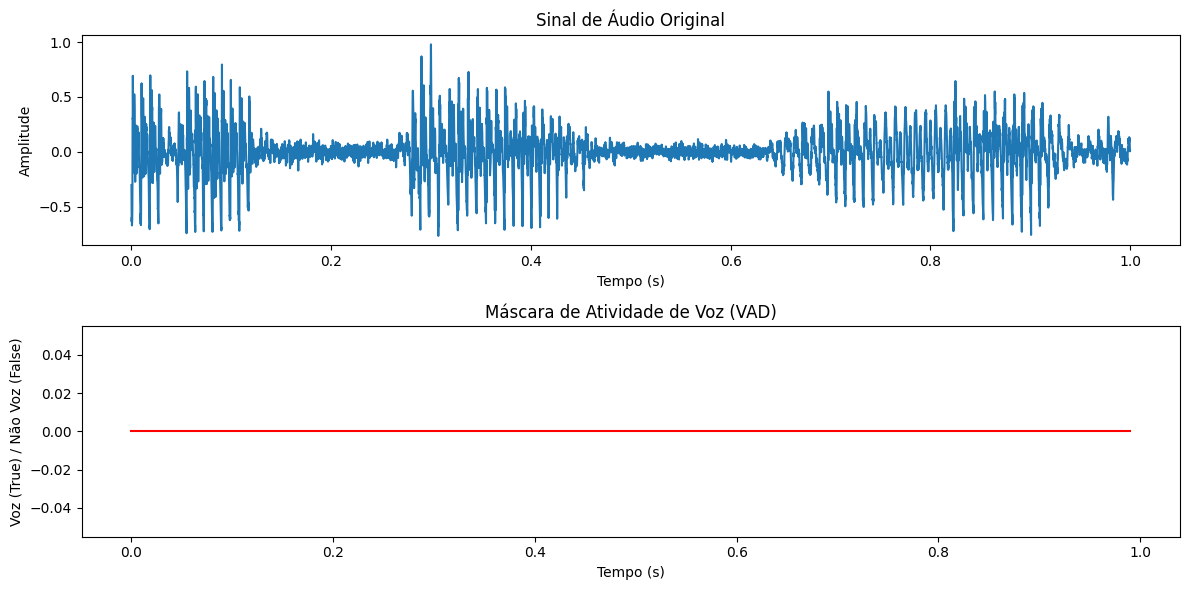

In [15]:
# Carregue seu sinal de áudio
x_batch, y_batch, metrics_batch_df = next(data_generator.generate_sample_metrics(250, 16, batch_size=1))

audio_signal = x_batch[0]
sample_rate = 8000
frame_shift_ms = 10

# Chame a função VAD
vad_mask = voice_activity_detection_advanced(x_batch[0])

# Plotar o sinal de áudio original
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(audio_signal)) / sample_rate, audio_signal)
plt.title('Sinal de Áudio Original')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')

# Plotar a máscara VAD como uma onda quadrada
plt.subplot(2, 1, 2)
plt.plot(np.arange(len(vad_mask)) * (frame_shift_ms / 1000.0), vad_mask, 'r')
plt.title('Máscara de Atividade de Voz (VAD)')
plt.xlabel('Tempo (s)')
plt.ylabel('Voz (True) / Não Voz (False)')

plt.tight_layout()
plt.show()